# Analysis of the ABIDE dataset

### Imports

In [1]:
import warnings
import os
from os.path import join
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import quantile_transform
from sklearn.metrics import roc_curve, RocCurveDisplay
from nilearn.datasets.utils import _uncompress_file, _fetch_file
from nilearn.connectome import ConnectivityMeasure

from neurocombat_sklearn import CombatModel

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.formula.api import ols as ols_f

from mlconfound.stats import full_confound_test, partial_confound_test
from mlconfound.plot import plot_graph
from mlconfound.stats import _r2_cat_cont, _r2_cont_cont, _r2_cat_cat

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## Load data

In [2]:
data_dir = '../data/ABIDE'

url = 'https://osf.io/hc4md/download'

# Download the zip file, first
dl_file = _fetch_file(url, data_dir=data_dir)

# Second, uncompress the downloaded zip file
_uncompress_file(dl_file, verbose=2)


Downloaded 1808302080 of 1811491701 bytes (99.8%,    0.3s remaining) ...done. (152 seconds, 2 min)
Extracting data from ../data/ABIDE/download..... done.


In [3]:
def _get_paths(phenotypic, atlas, timeseries_dir):
    timeseries = []
    IDs_subject = []
    diagnosis = []
    subject_ids = phenotypic['SUB_ID']
    mean_fd = []
    num_fd = []
    perc_fd = []
    site = []
    for index, subject_id in enumerate(subject_ids):
        this_pheno = phenotypic[phenotypic['SUB_ID'] == subject_id]
        this_timeseries = join(timeseries_dir, atlas,
                               str(subject_id) + '_timeseries.txt')
        if os.path.exists(this_timeseries):
            timeseries.append(np.loadtxt(this_timeseries))
            IDs_subject.append(subject_id)
            diagnosis.append(this_pheno['DX_GROUP'].values[0])
            mean_fd.append(this_pheno['func_mean_fd'].values[0])
            num_fd.append(this_pheno['func_num_fd'].values[0])
            perc_fd.append(this_pheno['func_perc_fd'].values[0])
            site.append(this_pheno['SITE_ID'].values[0])
    return timeseries, diagnosis, IDs_subject, mean_fd, num_fd, perc_fd, site

Download the phenotypic summary information file form the preprocessed connectomes project.
- First read:
  http://preprocessed-connectomes-project.org/abide/download.html
- Then download:
  https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv
- Copy the csv file into the data_in/ABIDE directory

In [4]:
phenotypic = pd.read_csv('../data/ABIDE/Phenotypic_V1_0b_preprocessed1.csv').iloc[:,2:]
timeseries, diagnosis, IDs_subject, mean_fd, num_fd, perc_fd, site = _get_paths(phenotypic, "BASC/regions", '../data/ABIDE/')
sites, site_int = np.unique(site, return_inverse=True)
phenotypic.columns.values

array(['SUB_ID', 'X', 'subject', 'SITE_ID', 'FILE_ID', 'DX_GROUP',
       'DSM_IV_TR', 'AGE_AT_SCAN', 'SEX', 'HANDEDNESS_CATEGORY',
       'HANDEDNESS_SCORES', 'FIQ', 'VIQ', 'PIQ', 'FIQ_TEST_TYPE',
       'VIQ_TEST_TYPE', 'PIQ_TEST_TYPE', 'ADI_R_SOCIAL_TOTAL_A',
       'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 'ADI_R_ONSET_TOTAL_D',
       'ADI_R_RSRCH_RELIABLE', 'ADOS_MODULE', 'ADOS_TOTAL', 'ADOS_COMM',
       'ADOS_SOCIAL', 'ADOS_STEREO_BEHAV', 'ADOS_RSRCH_RELIABLE',
       'ADOS_GOTHAM_SOCAFFECT', 'ADOS_GOTHAM_RRB', 'ADOS_GOTHAM_TOTAL',
       'ADOS_GOTHAM_SEVERITY', 'SRS_VERSION', 'SRS_RAW_TOTAL',
       'SRS_AWARENESS', 'SRS_COGNITION', 'SRS_COMMUNICATION',
       'SRS_MOTIVATION', 'SRS_MANNERISMS', 'SCQ_TOTAL', 'AQ_TOTAL',
       'COMORBIDITY', 'CURRENT_MED_STATUS', 'MEDICATION_NAME',
       'OFF_STIMULANTS_AT_SCAN', 'VINELAND_RECEPTIVE_V_SCALED',
       'VINELAND_EXPRESSIVE_V_SCALED', 'VINELAND_WRITTEN_V_SCALED',
       'VINELAND_COMMUNICATION_STANDARD', 'VINELAND_PERSONAL_V_S

(41.170464362909215, 5.142594423450439)

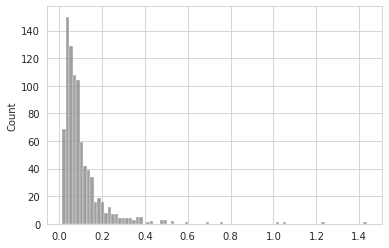

In [5]:
sns.histplot(mean_fd, color='gray')
kurtosis(mean_fd), skew(mean_fd)

(0.492398885189945, 0.6060249878053774)

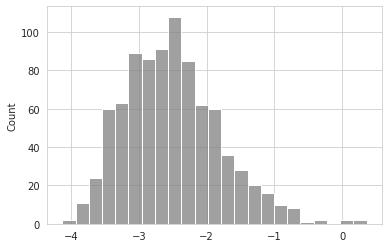

In [6]:
sns.histplot(np.log(mean_fd), color='gray')
kurtosis(np.log(mean_fd)), skew(np.log(mean_fd))

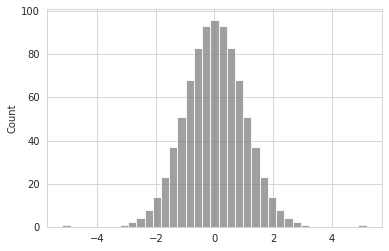

In [7]:
rng = np.random.default_rng(42)
mean_fd_trf = quantile_transform(np.array([mean_fd]).T, output_distribution='normal',
                                 n_quantiles=len(mean_fd)).flatten()

sns.histplot(mean_fd_trf, color='gray')

kurtosis(mean_fd_trf), skew(mean_fd_trf)
mean_fd = mean_fd_trf


## Binning motion data (to be used later)

In [8]:
# binning mean_fd
bins = 10 # approximately 80 subject per motion group

limits = np.quantile(mean_fd, np.arange(0, 1, 1/bins))
mean_fd_binned = np.digitize(mean_fd, limits)

## Calculate connectivity

In [9]:
connections = ConnectivityMeasure(kind='tangent', vectorize=True, discard_diagonal=True)
conn_coefs = connections.fit_transform(timeseries)

In [10]:
_, y = np.unique(diagnosis, return_inverse=True)
X = conn_coefs

# Machine learning (raw)

In [11]:
outer_cv = StratifiedKFold(10)
inner_cv = StratifiedKFold(10) 
model = Pipeline([
    ('varthr', VarianceThreshold(0)),   # omit zero variance columns (diagonal)
    ('model', LogisticRegression())])

p_grid = {'model__C': [0.1, 1, 10]}

clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=StratifiedKFold(10),
                   scoring="roc_auc", return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
predicted_prob = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):

    clf.fit(X[train], y[train])
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X[test])
    predicted_prob[test] = clf.predict_proba(X[test])[:,0]
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X[test], y[test])
    i = i+1

model	inner_cv mean score	outer vc score
cv: 0 {'model__C': 0.1} 0.7100334219236659 0.690880169671262
cv: 1 {'model__C': 0.1} 0.7120691684716075 0.6458112407211029
cv: 2 {'model__C': 0.1} 0.7018831113343309 0.6851063829787234
cv: 3 {'model__C': 0.1} 0.683804187462724 0.8202127659574467
cv: 4 {'model__C': 1} 0.6986948621094962 0.7351063829787234
cv: 5 {'model__C': 0.1} 0.7201791512767122 0.6872340425531914
cv: 6 {'model__C': 0.1} 0.6974297468199907 0.7592391304347826
cv: 7 {'model__C': 0.1} 0.7031858949541876 0.7597826086956522
cv: 8 {'model__C': 0.1} 0.7127732261878603 0.7440217391304348
cv: 9 {'model__C': 0.1} 0.7333955035174546 0.6059782608695652


** Mean score in the inner crossvaludation (inner_cv):	0.7073448274058031
** Mean Nested Crossvalidation Score (outer_cv):	0.7133372723990885


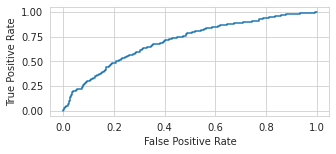

In [12]:
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))

fpr, tpr, _ = roc_curve(y, predicted_prob, pos_label=0)
fig, ax = plt.subplots(figsize=(5,2))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax) 
#plt.savefig('../fig/raw/emp_abide_raw_rocplot.pdf')


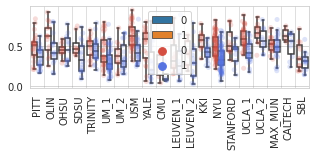

In [13]:
plt.figure(figsize=(5,1.5))

pal=[sns.color_palette("coolwarm", 10)[-1], sns.color_palette("coolwarm", 10)[0]]
sns.stripplot(x=site, y=predicted_prob, hue=y, palette=pal, alpha=0.2, jitter=0.2, dodge=True)
ax=sns.boxplot(x=site, y=predicted_prob, hue=y, showfliers = False)
for box in ax.artists:
    box.set_facecolor((1,1,1,0))
plt.xticks(rotation=90)
for i in range(len(np.unique(site))):
    plt.axvline(i+0.5, color="gray", alpha=0.5, linewidth=0.5)

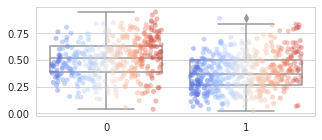

In [14]:
plt.figure(figsize=(5,2))
sns.stripplot(x=y, y=predicted_prob, hue=mean_fd_binned,
              palette="coolwarm", alpha=0.4, jitter=0.4, dodge=True)
sns.boxplot(x=y, y=predicted_prob, color=(1,1,1,1))
plt.legend([],[], frameon=False)

Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 503.73it/s]


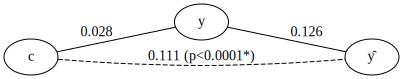

In [15]:
plot_graph(partial_confound_test(y, predicted_prob, mean_fd, cat_y=True, cat_yhat=False,
                                     random_state=42))

Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 370.49it/s]


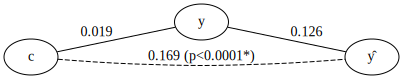

In [16]:
plot_graph(partial_confound_test(y, predicted_prob, site_int,
                                     cat_y=True, cat_yhat=False, cat_c=True,
                                     random_state=42))

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


ShapiroResult(statistic=0.9949164390563965, pvalue=0.2088082879781723)


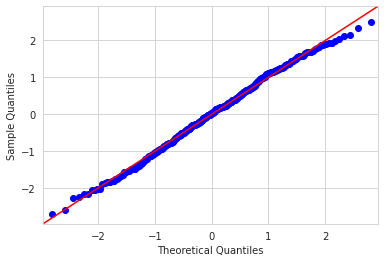

ShapiroResult(statistic=0.9875282049179077, pvalue=0.0005295461160130799)


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


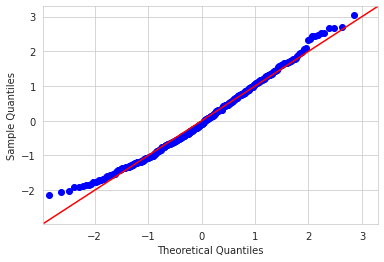

In [17]:
from scipy.stats import shapiro
import statsmodels.api as sm
import matplotlib.pyplot as plt

for l in [0, 1]:
    data = predicted_prob[y==l]
    data = (data - np.mean(data)) / np.std(data)
    #sns.distplot(data)
    print(shapiro(data))
    plt.show()
    sm.qqplot(data, line='45')
    plt.show()


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: Use

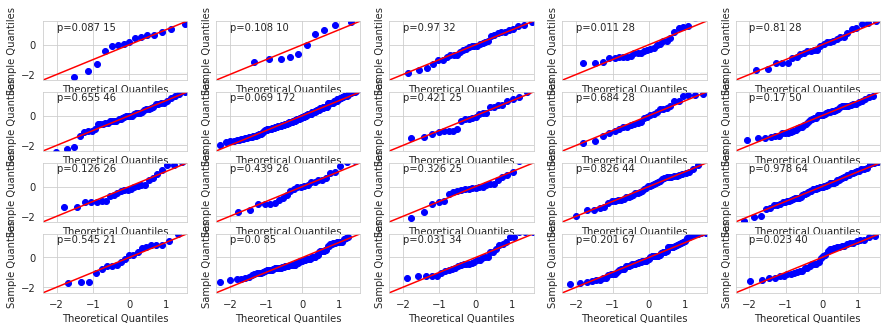

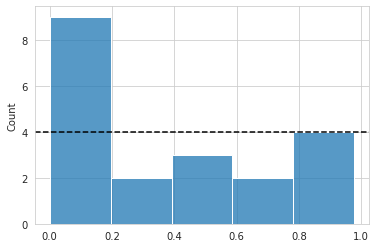

In [18]:
fig, axes = plt.subplots(4,5, figsize = (15,5), sharex=True, sharey=True)

pvals = []

l=0
for ax in axes.flatten():
    data = predicted_prob[site_int==l]
    data = (data - np.mean(data)) / np.std(data)
    #sns.distplot(data)
    res = shapiro(data)
    sm.qqplot(data, line='45', ax=ax)
    ax.annotate('p=' + str(np.round(res.pvalue, 3)) + ' ' + str(len(data)), xy=(-2,1))
    pvals.append(res.pvalue)
    l+=1
plt.show()

#from statsmodels.stats.multitest import fdrcorrection
#fdrcorrection(pvals)
sns.histplot(pvals, bins=5)
plt.axhline(4, color='black', linestyle='dashed')

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: Use

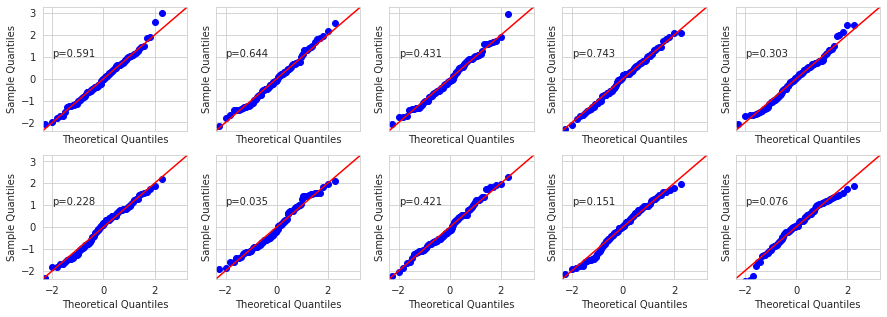

(array([False, False, False, False, False, False, False, False, False,
        False]),
 array([0.71592066, 0.71592066, 0.61533302, 0.7434333 , 0.60673982,
        0.57071738, 0.34692027, 0.61533302, 0.50432245, 0.37820317]))

In [19]:
fig, axes = plt.subplots(2,5, figsize = (15,5), sharex=True, sharey=True)

pvals = []

l=1
for ax in axes.flatten():
    data = predicted_prob[mean_fd_binned==l]
    data = (data - np.mean(data)) / np.std(data)
    #sns.distplot(data)
    res = shapiro(data)
    sm.qqplot(data, line='45', ax=ax)
    ax.annotate('p=' + str(np.round(res.pvalue, 3)), xy=(-2,1))
    pvals.append(res.pvalue)
    l+=1
plt.show()

from statsmodels.stats.multitest import fdrcorrection
fdrcorrection(pvals)

In [20]:
import pingouin as pg

df_tmp = pd.DataFrame({
    'x': mean_fd,
    'y': predicted,
    'c': y
})
# partial correlation
res_parcor_pearson = pg.partial_corr(data=df_tmp, x='x', y='y', covar='c',
                                     method='pearson')
# partial correlation
res_parcor_spearman = pg.partial_corr(data=df_tmp, x='x', y='y', covar='c',
                                     method='spearman')
res_parcor_spearman['p-val'], res_parcor_pearson['p-val']

(spearman    4.319800e-15
 Name: p-val, dtype: float64,
 pearson    1.272232e-16
 Name: p-val, dtype: float64)

# Regress out motion from the feature

In [21]:
# regress-out motion from connectivity
X_adj = np.zeros_like(X)
for i in range(X.shape[1]):
    OLS_model = OLS(X[:,i], sm.add_constant(mean_fd)).fit()  # training the model
    X_adj[:, i] = OLS_model.resid

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [29]:
outer_cv = StratifiedKFold(10)
inner_cv = StratifiedKFold(10) 
model = Pipeline([
    ('varthr', VarianceThreshold(0)),   # omit zero variance columns (diagonal)
    #('fsel', SelectKBest(f_regression)),
    ('model', LogisticRegression())])

p_grid = {#'fsel__k': [500, 1000, 2000],
          'model__C': [0.1, 1, 10]}

clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=StratifiedKFold(10),
                   scoring="roc_auc", return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
predicted_prob = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X_adj))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X_adj))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):

    clf.fit(X_adj[train], y[train])
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_adj[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X_adj[test])
    predicted_prob[test] = clf.predict_proba(X_adj[test])[:,0]
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_adj[test], y[test])
    i = i+1

model	inner_cv mean score	outer vc score
cv: 0 {'model__C': 0.1} 0.575732134573598 0.679745493107105
cv: 1 {'model__C': 0.1} 0.5862695012085257 0.5922587486744432
cv: 2 {'model__C': 0.1} 0.5971689023518292 0.5494680851063829
cv: 3 {'model__C': 0.1} 0.5795941847771116 0.6558510638297872
cv: 4 {'model__C': 0.1} 0.5901033873594849 0.6446808510638298
cv: 5 {'model__C': 0.1} 0.6414546515156271 0.45
cv: 6 {'model__C': 0.1} 0.5846736980883322 0.6701086956521739
cv: 7 {'model__C': 0.1} 0.6039699542748325 0.5945652173913043
cv: 8 {'model__C': 0.1} 0.6184660706002169 0.5201086956521739
cv: 9 {'model__C': 0.1} 0.6278473595546766 0.5266304347826086


** Mean score in the inner crossvaludation (inner_cv):	0.6005279844304235
** Mean Nested Crossvalidation Score (outer_cv):	0.5883417285259809


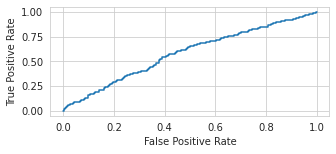

In [30]:
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))

fpr, tpr, _ = roc_curve(y, predicted_prob, pos_label=0)
fig, ax = plt.subplots(figsize=(5,2))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax) 
#plt.savefig('../fig/raw/emp_abide_motion_reg_rocplot.pdf')
    

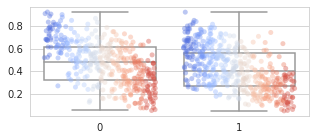

In [31]:
plt.figure(figsize=(5,2))
sns.stripplot(x=y, y=predicted_prob, hue=mean_fd_binned,
              palette="coolwarm", alpha=0.4, jitter=0.4, dodge=True)
sns.boxplot(x=y, y=predicted_prob, color=(1,1,1,1))
plt.legend([],[], frameon=False)
#plt.savefig('../fig/raw/emp_abide_motion_reg_stripplot.pdf')

Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 651.17it/s]


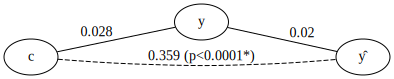

In [32]:
plot_graph(partial_confound_test(y, predicted_prob, mean_fd, cat_y=True, cat_yhat=False,
                                     random_state=42))

In [33]:
nulldist = []
unpermuted = _r2_cont_cont(predicted_prob, mean_fd)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted_prob)
    nulldist.append(_r2_cont_cont(yperm, mean_fd))
(nulldist >= unpermuted).sum()/len(nulldist)

0.35940432840757963


0.0

In [34]:
nulldist = []
unpermuted = _r2_cat_cont(y, predicted_prob)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted_prob)
    nulldist.append(_r2_cat_cont(y, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)

0.01983830774607609


0.0

ShapiroResult(statistic=0.988394558429718, pvalue=0.002758632181212306)


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


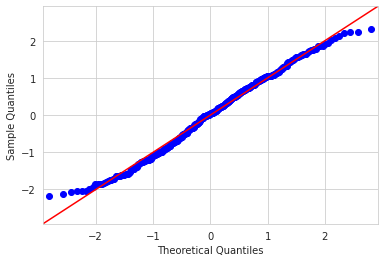

ShapiroResult(statistic=0.9783481359481812, pvalue=2.154746425730991e-06)


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


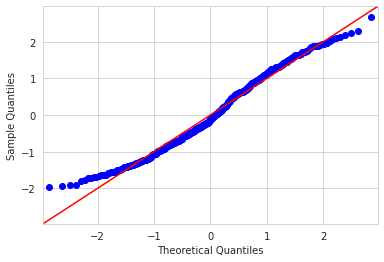

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: Use

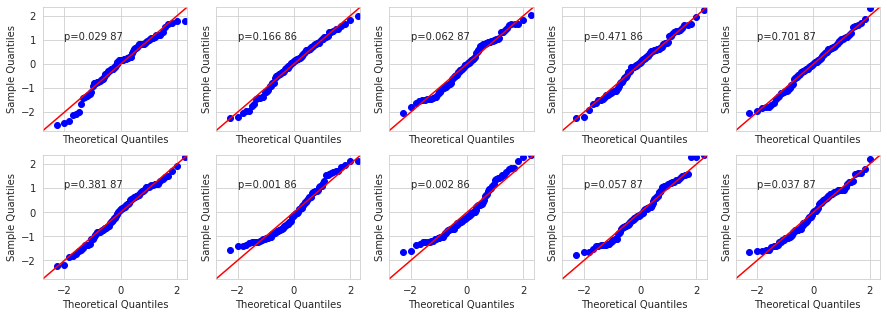

(spearman    8.188109e-69
 Name: p-val, dtype: float64,
 pearson    1.407413e-65
 Name: p-val, dtype: float64)

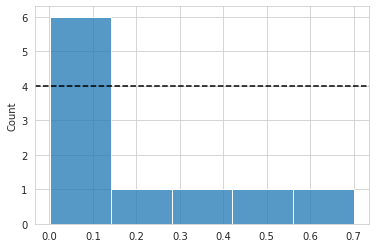

In [37]:
from scipy.stats import shapiro
import statsmodels.api as sm
import matplotlib.pyplot as plt

for l in [0, 1]:
    data = predicted_prob[y == l]
    data = (data - np.mean(data)) / np.std(data)
    #sns.distplot(data)
    print(shapiro(data))
    plt.show()
    sm.qqplot(data, line='45')
    plt.show()

fig, axes = plt.subplots(2, 5, figsize=(15, 5), sharex=True, sharey=True)

pvals = []

l = 1
for ax in axes.flatten():
    data = predicted_prob[mean_fd_binned == l]
    data = (data - np.mean(data)) / np.std(data)
    #sns.distplot(data)
    res = shapiro(data)
    sm.qqplot(data, line='45', ax=ax)
    ax.annotate('p=' + str(np.round(res.pvalue, 3)) + ' ' + str(len(data)), xy=(-2, 1))
    pvals.append(res.pvalue)
    l += 1
plt.show()

sns.histplot(pvals, bins=5)
plt.axhline(4, color='black', linestyle='dashed')

pvals = []

from statsmodels.stats.multitest import fdrcorrection
fdrcorrection(pvals)

import pingouin as pg

df_tmp = pd.DataFrame({
    'x': mean_fd,
    'y': predicted,
    'c': y
})
# partial correlation
res_parcor_pearson = pg.partial_corr(data=df_tmp, x='x', y='y', covar='c',
                                     method='pearson')
# partial correlation
res_parcor_spearman = pg.partial_corr(data=df_tmp, x='x', y='y', covar='c',
                                      method='spearman')
res_parcor_spearman['p-val'], res_parcor_pearson['p-val']

# Regress out site

In [38]:
# regress-out acquisition from connectivity
X_adj = np.zeros_like(X)
for i in range(X.shape[1]):
    tmp = pd.DataFrame({
        'x': site_int,
        'y': X[:,i]
    })
    OLS_model = ols_f("y ~ C(x)", tmp).fit()  # training the model
    X_adj[:, i] = OLS_model.resid.values

In [39]:
outer_cv = StratifiedKFold(10)
inner_cv = StratifiedKFold(10) 
model = Pipeline([
    ('varthr', VarianceThreshold(0)),   # omit zero variance columns (diagonal)
    #('fsel', SelectKBest(f_regression)),
    ('model', LogisticRegression())])

p_grid = {#'fsel__k': [500, 1000, 2000],
          'model__C': [0.1, 1, 10]}

clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=StratifiedKFold(10),
                   scoring="roc_auc", return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
predicted_prob = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X_adj))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X_adj))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):

    clf.fit(X_adj[train], y[train])
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_adj[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X_adj[test])
    predicted_prob[test] = clf.predict_proba(X_adj[test])[:,0]
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_adj[test], y[test])
    i = i+1

model	inner_cv mean score	outer vc score
cv: 0 {'model__C': 0.1} 0.7512998189827458 0.6956521739130435
cv: 1 {'model__C': 0.1} 0.7602222431490724 0.653764581124072
cv: 2 {'model__C': 0.1} 0.7382248101760297 0.7797872340425532
cv: 3 {'model__C': 10} 0.7533220502732698 0.8308510638297872
cv: 4 {'model__C': 0.1} 0.7311433384604116 0.7856382978723404
cv: 5 {'model__C': 0.1} 0.7137365152609055 0.8664893617021276
cv: 6 {'model__C': 0.1} 0.7290465552660674 0.7478260869565218
cv: 7 {'model__C': 0.1} 0.7255997722461138 0.8108695652173913
cv: 8 {'model__C': 0.1} 0.737317238841629 0.771195652173913
cv: 9 {'model__C': 0.1} 0.7495317617268836 0.6157608695652174


** Mean score in the inner crossvaludation (inner_cv):	0.7389444104383128
** Mean Nested Crossvalidation Score (outer_cv):	0.7557834886396967


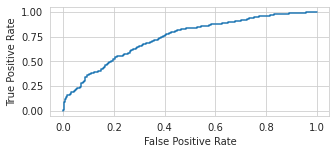

In [40]:
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))

fpr, tpr, _ = roc_curve(y, predicted_prob, pos_label=0)
fig, ax = plt.subplots(figsize=(5,2))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax) 
#plt.savefig('../fig/raw/emp_abide_site_reg_rocplot.pdf')
    

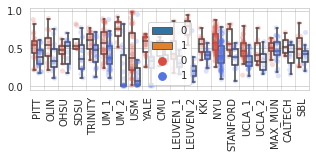

In [41]:
plt.figure(figsize=(5,1.5))

pal=[sns.color_palette("coolwarm", 10)[-1], sns.color_palette("coolwarm", 10)[0]]
sns.stripplot(x=site, y=predicted_prob, hue=y, palette=pal, alpha=0.2, jitter=0.2, dodge=True)
ax=sns.boxplot(x=site, y=predicted_prob, hue=y, showfliers = False)
for box in ax.artists:
    box.set_facecolor((1,1,1,0))
plt.xticks(rotation=90)
for i in range(len(np.unique(site))):
    plt.axvline(i+0.5, color="gray", alpha=0.5, linewidth=0.5)
#plt.savefig('../fig/raw/emp_abide_site_reg_striplot.pdf')

Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 341.36it/s]


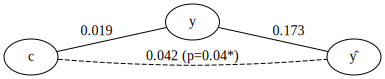

In [42]:
plot_graph(partial_confound_test(y, predicted_prob, site_int,
                                     cat_y=True, cat_yhat=False, cat_c=True,
                                     random_state=42))

In [43]:
nulldist = []
unpermuted = _r2_cat_cont(site_int, predicted_prob)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted_prob)
    nulldist.append(_r2_cat_cont(site_int, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)

0.04243881759371848


0.011

In [44]:
nulldist = []
unpermuted = _r2_cat_cont(y, predicted_prob)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted_prob)
    nulldist.append(_r2_cat_cont(y, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)


0.1730211479165208


0.0

ShapiroResult(statistic=0.9953939914703369, pvalue=0.2823885381221771)


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


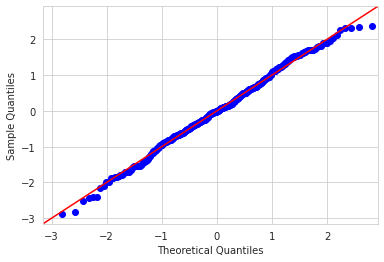

ShapiroResult(statistic=0.9917308688163757, pvalue=0.011015290394425392)


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


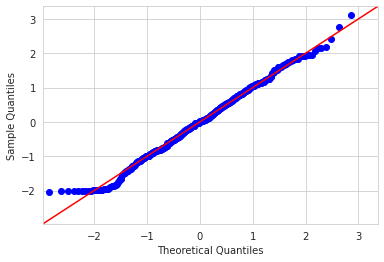

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: Use

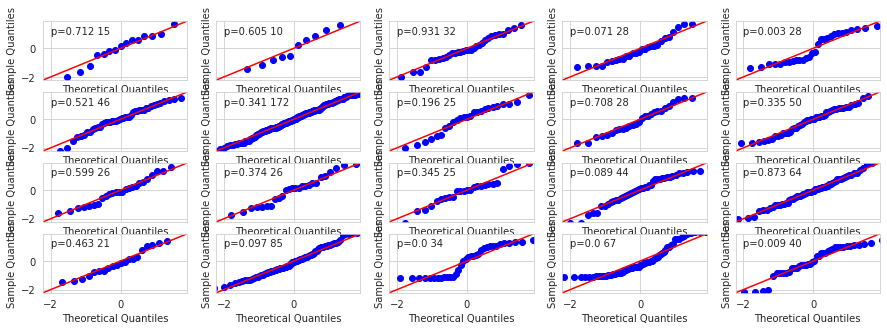

(spearman    0.084293
 Name: p-val, dtype: float64,
 pearson    0.081844
 Name: p-val, dtype: float64)

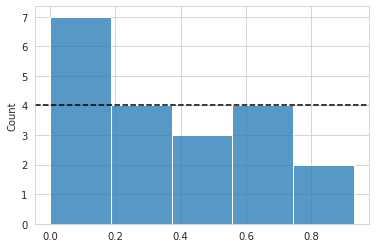

In [46]:
from scipy.stats import shapiro
import statsmodels.api as sm
import matplotlib.pyplot as plt

for l in [0, 1]:
    data = predicted_prob[y == l]
    data = (data - np.mean(data)) / np.std(data)
    #sns.distplot(data)
    print(shapiro(data))
    plt.show()
    sm.qqplot(data, line='45')
    plt.show()

fig, axes = plt.subplots(4, 5, figsize=(15, 5), sharex=True, sharey=True)

pvals = []

l = 0
for ax in axes.flatten():
    data = predicted_prob[site_int == l]
    data = (data - np.mean(data)) / np.std(data)
    #sns.distplot(data)
    res = shapiro(data)
    sm.qqplot(data, line='45', ax=ax)
    ax.annotate('p=' + str(np.round(res.pvalue, 3)) + ' ' + str(len(data)), xy=(-2, 1))
    pvals.append(res.pvalue)
    l += 1
plt.show()


sns.histplot(pvals, bins=5)
plt.axhline(4, color='black', linestyle='dashed')

from statsmodels.stats.multitest import fdrcorrection
fdrcorrection(pvals)

import pingouin as pg

df_tmp = pd.DataFrame({
    'x': site_int,
    'y': predicted,
    'c': y
})
# partial correlation
res_parcor_pearson = pg.partial_corr(data=df_tmp, x='x', y='y', covar='c',
                                     method='pearson')
# partial correlation
res_parcor_spearman = pg.partial_corr(data=df_tmp, x='x', y='y', covar='c',
                                      method='spearman')
res_parcor_spearman['p-val'], res_parcor_pearson['p-val']

# Above, this is NOT detected by partial correlation methods, probably due to non-Gaussianity of the conditional distributions yhat|y and yhat|c

# Combat on binned motion data

In [47]:
outer_cv = StratifiedKFold(10)
inner_cv = StratifiedKFold(10) 
model = Pipeline([
    ('varthr', VarianceThreshold(0)),   # omit zero variance columns (diagonal)
    #('fsel', SelectKBest(f_regression)),
    ('model', LogisticRegression())])

p_grid = {#'fsel__k': [500, 1000, 2000],
          'model__C': [0.1, 1, 10]}

clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=StratifiedKFold(10),
                   scoring="roc_auc", return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
predicted_prob = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):
    
    comb = CombatModel()
    X_train_combat = comb.fit_transform(X[:,np.sum(X,0)!=0][train],
                                   np.array([mean_fd_binned[train]]).transpose()
                                  )


    clf.fit(X_train_combat, y[train])
    
    X_test_combat = comb.transform(X[:,np.sum(X,0)!=0][test],
                                   np.array([mean_fd_binned[test]]).transpose())

                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_test_combat, y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X_test_combat)
    predicted_prob[test] = clf.predict_proba(X_test_combat)[:,0]
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_test_combat, y[test])
    i = i+1

model	inner_cv mean score	outer vc score
cv: 0 {'model__C': 0.1} 0.6645641721861234 0.7067868504772005
cv: 1 {'model__C': 0.1} 0.6695913247742515 0.6813361611876988
cv: 2 {'model__C': 0.1} 0.6594625984869887 0.6930851063829787
cv: 3 {'model__C': 0.1} 0.6608973956534931 0.8074468085106383
cv: 4 {'model__C': 0.1} 0.6629321394565297 0.7287234042553191
cv: 5 {'model__C': 0.1} 0.7064102865932134 0.6425531914893616
cv: 6 {'model__C': 0.1} 0.6678523035230352 0.7581521739130436
cv: 7 {'model__C': 0.1} 0.6746544453861528 0.7472826086956521
cv: 8 {'model__C': 0.1} 0.6961607077460735 0.6646739130434782
cv: 9 {'model__C': 0.1} 0.6957503670918306 0.5815217391304348


** Mean score in the inner crossvaludation (inner_cv):	0.6758275740897691
** Mean Nested Crossvalidation Score (outer_cv):	0.7011561957085806


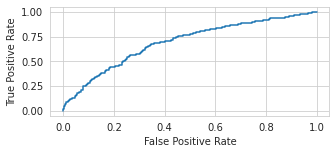

In [48]:
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))

fpr, tpr, _ = roc_curve(y, predicted_prob, pos_label=0)
fig, ax = plt.subplots(figsize=(5,2))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax) 
#plt.savefig('../fig/raw/emp_abide_motion_comb_rocplot.pdf')
    

<AxesSubplot:>

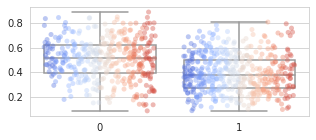

In [49]:
plt.figure(figsize=(5,2))
sns.stripplot(x=y, y=predicted_prob, hue=mean_fd_binned,
              palette="coolwarm", alpha=0.4, jitter=0.4, dodge=True)
plt.legend([],[], frameon=False)
sns.boxplot(x=y, y=predicted_prob, color=(1,1,1,1))
#plt.savefig('../fig/raw/emp_abide_motion_comb_stripplot.pdf')

Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 576.42it/s]


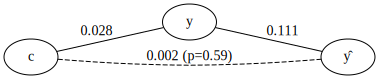

In [50]:
plot_graph(partial_confound_test(y, predicted_prob, mean_fd, cat_y=True, cat_yhat=False,
                                     random_state=42))

In [51]:
nulldist = []
unpermuted = _r2_cont_cont(predicted_prob, mean_fd)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted_prob)
    nulldist.append(_r2_cont_cont(yperm, mean_fd))
(nulldist >= unpermuted).sum()/len(nulldist)

0.001963925089027347


0.208

In [52]:
nulldist = []
unpermuted = _r2_cat_cont(y, predicted_prob)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted_prob)
    nulldist.append(_r2_cat_cont(y, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)

0.11138396090241687


0.0

ShapiroResult(statistic=0.9920635223388672, pvalue=0.03068968467414379)


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


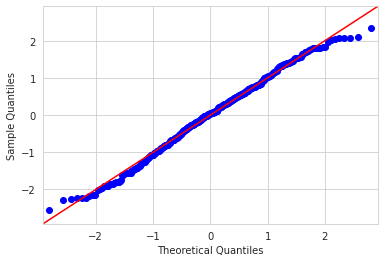

ShapiroResult(statistic=0.9817016124725342, pvalue=1.3781133930024225e-05)


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


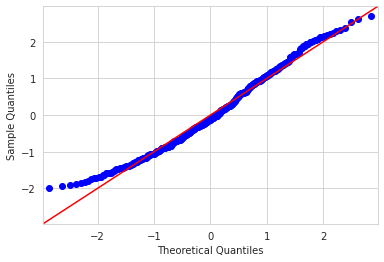

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: Use

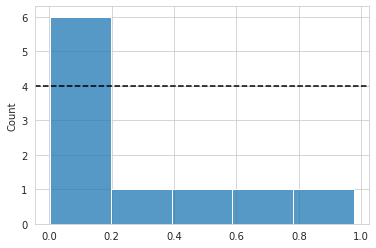

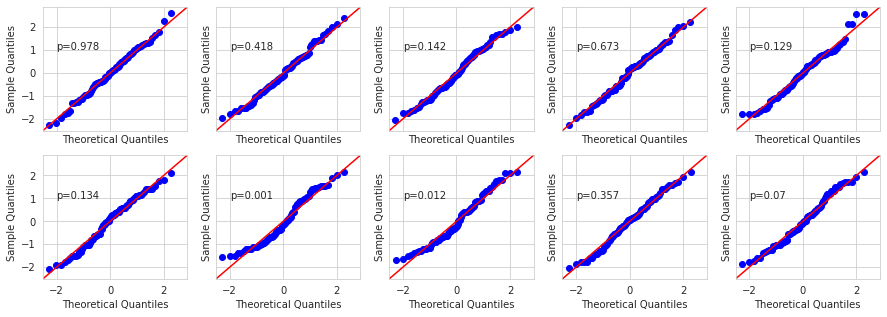

(array([False, False, False, False, False, False,  True, False, False,
       False]), array([0.97751939, 0.52194525, 0.23731401, 0.74811578, 0.23731401,
       0.23731401, 0.01348373, 0.05783856, 0.50970184, 0.23382636]))


(spearman    0.436667
 Name: p-val, dtype: float64,
 pearson    0.935646
 Name: p-val, dtype: float64)

In [54]:
from scipy.stats import shapiro
import statsmodels.api as sm
import matplotlib.pyplot as plt

for l in [0, 1]:
    data = predicted_prob[y == l]
    data = (data - np.mean(data)) / np.std(data)
    #sns.distplot(data)
    print(shapiro(data))
    plt.show()
    sm.qqplot(data, line='45')
    plt.show()

#from statsmodels.stats.multitest import fdrcorrection
#fdrcorrection(pvals)
sns.histplot(pvals, bins=5)
plt.axhline(4, color='black', linestyle='dashed')
fig, axes = plt.subplots(2, 5, figsize=(15, 5), sharex=True, sharey=True)

pvals = []

l = 1
for ax in axes.flatten():
    data = predicted_prob[mean_fd_binned == l]
    data = (data - np.mean(data)) / np.std(data)
    #sns.distplot(data)
    res = shapiro(data)
    sm.qqplot(data, line='45', ax=ax)
    ax.annotate('p=' + str(np.round(res.pvalue, 3)), xy=(-2, 1))
    pvals.append(res.pvalue)
    l += 1
plt.show()

from statsmodels.stats.multitest import fdrcorrection

print(fdrcorrection(pvals))
import pingouin as pg

df_tmp = pd.DataFrame({
    'x': mean_fd,
    'y': predicted,
    'c': y
})
# partial correlation
res_parcor_pearson = pg.partial_corr(data=df_tmp, x='x', y='y', covar='c',
                                     method='pearson')
# partial correlation
res_parcor_spearman = pg.partial_corr(data=df_tmp, x='x', y='y', covar='c',
                                      method='spearman')
res_parcor_spearman['p-val'], res_parcor_pearson['p-val']

# Combat on site

In [55]:
outer_cv = StratifiedKFold(10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(10, shuffle=True, random_state=42) 
model = Pipeline([
    ('varthr', VarianceThreshold(0)),   # omit zero variance columns (diagonal)
    #('fsel', SelectKBest(f_regression)),
    ('model', LogisticRegression())])

p_grid = {#'fsel__k': [500, 1000, 2000],
          'model__C': [0.1, 1, 10]}

clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=StratifiedKFold(10),
                   scoring="roc_auc", return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
predicted_prob = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):
    
    comb = CombatModel()
    X_train_combat = comb.fit_transform(X[:,np.sum(X,0)!=0][train],
                                   np.array([site_int[train]]).transpose()
                                  )


    clf.fit(X_train_combat, y[train])
    
    X_test_combat = comb.transform(X[:,np.sum(X,0)!=0][test],
                                   np.array([site_int[test]]).transpose())

                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_test_combat, y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X_test_combat)
    predicted_prob[test] = clf.predict_proba(X_test_combat)[:,0]
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_test_combat, y[test])
    i = i+1

model	inner_cv mean score	outer vc score
cv: 0 {'model__C': 0.1} 0.7501508477118233 0.7290562036055144
cv: 1 {'model__C': 0.1} 0.7358902020487387 0.7576882290562036
cv: 2 {'model__C': 0.1} 0.7447366355902941 0.7026595744680851
cv: 3 {'model__C': 0.1} 0.7346093044263775 0.7696808510638298
cv: 4 {'model__C': 0.1} 0.7258576084795597 0.7973404255319149
cv: 5 {'model__C': 0.1} 0.751687881261052 0.6675531914893617
cv: 6 {'model__C': 1} 0.7394399626106943 0.7913043478260869
cv: 7 {'model__C': 1} 0.7423432578920385 0.7369565217391304
cv: 8 {'model__C': 0.1} 0.7492881383125284 0.7266304347826087
cv: 9 {'model__C': 0.1} 0.7345418589321029 0.7728260869565218


** Mean score in the inner crossvaludation (inner_cv):	0.740854569726521
** Mean Nested Crossvalidation Score (outer_cv):	0.7451695866519257


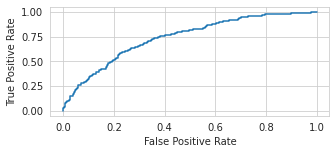

In [56]:
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))

fpr, tpr, _ = roc_curve(y, predicted_prob, pos_label=0)
fig, ax = plt.subplots(figsize=(5,2))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax) 
#plt.savefig('../fig/raw/emp_abide_site_comb_rocplot.pdf')

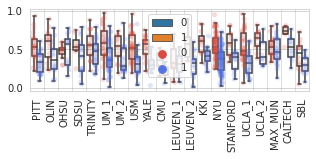

In [57]:
plt.figure(figsize=(5,1.5))

pal=[sns.color_palette("coolwarm", 10)[-1], sns.color_palette("coolwarm", 10)[0]]
sns.stripplot(x=site, y=predicted_prob, hue=y, palette=pal, alpha=0.2, jitter=0.2, dodge=True)
ax=sns.boxplot(x=site, y=predicted_prob, hue=y, showfliers = False)
for box in ax.artists:
    box.set_facecolor((1,1,1,0))
plt.xticks(rotation=90)
for i in range(len(np.unique(site))):
    plt.axvline(i+0.5, color="gray", alpha=0.5, linewidth=0.5)
#plt.savefig('../fig/raw/emp_abide_site_comb_striplot.pdf')

Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 391.81it/s]


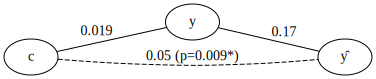

In [58]:
plot_graph(partial_confound_test(y, predicted_prob, site_int,
                                     cat_y=True, cat_yhat=False, cat_c=True,
                                     random_state=42))

In [59]:
nulldist = []
unpermuted = _r2_cat_cont(site_int, predicted_prob)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted_prob)
    nulldist.append(_r2_cat_cont(site_int, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)

0.04978966375151461


0.001

In [60]:
nulldist = []
unpermuted = _r2_cat_cont(y, predicted_prob)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted_prob)
    nulldist.append(_r2_cat_cont(y, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)


0.17032841128735843


0.0

ShapiroResult(statistic=0.9959964156150818, pvalue=0.4043298363685608)


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


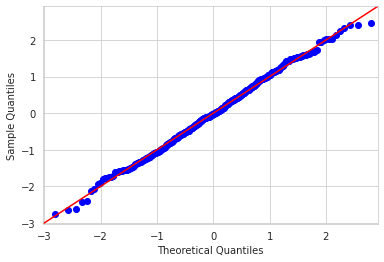

ShapiroResult(statistic=0.9853042364120483, pvalue=0.00012249028077349067)


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


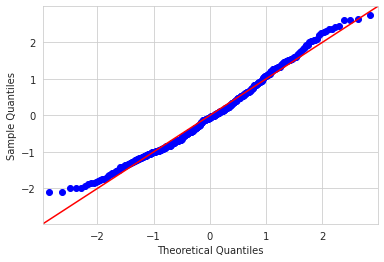

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: Use

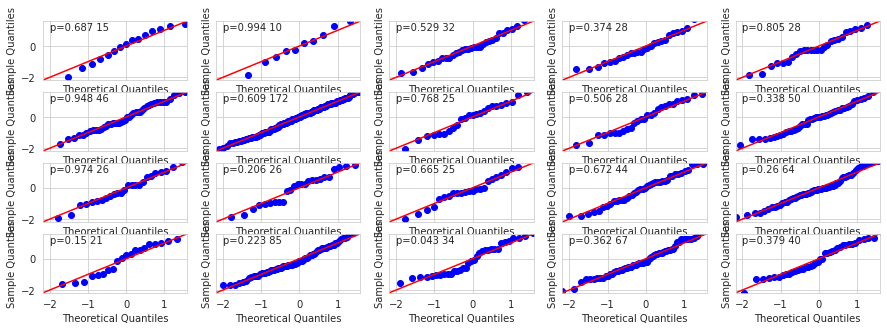

(array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), array([0.91543118, 0.99388224, 0.91543118, 0.84260596, 0.94718295,
       0.99388224, 0.91543118, 0.94718295, 0.91543118, 0.84260596,
       0.99388224, 0.84260596, 0.91543118, 0.91543118, 0.84260596,
       0.84260596, 0.84260596, 0.84260596, 0.84260596, 0.84260596]))


(spearman    0.835942
 Name: p-val, dtype: float64,
 pearson    0.845596
 Name: p-val, dtype: float64)

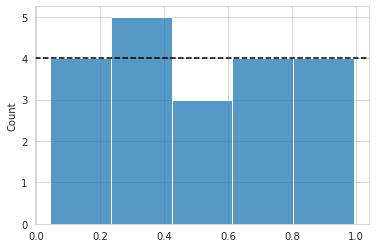

In [61]:
from scipy.stats import shapiro
import statsmodels.api as sm
import matplotlib.pyplot as plt

for l in [0, 1]:
    data = predicted_prob[y == l]
    data = (data - np.mean(data)) / np.std(data)
    #sns.distplot(data)
    print(shapiro(data))
    plt.show()
    sm.qqplot(data, line='45')
    plt.show()

fig, axes = plt.subplots(4, 5, figsize=(15, 5), sharex=True, sharey=True)

pvals = []

l = 0
for ax in axes.flatten():
    data = predicted_prob[site_int == l]
    data = (data - np.mean(data)) / np.std(data)
    #sns.distplot(data)
    res = shapiro(data)
    sm.qqplot(data, line='45', ax=ax)
    ax.annotate('p=' + str(np.round(res.pvalue, 3)) + ' ' + str(len(data)), xy=(-2, 1))
    pvals.append(res.pvalue)
    l += 1
plt.show()

from statsmodels.stats.multitest import fdrcorrection
print(fdrcorrection(pvals))

sns.histplot(pvals, bins=5)
plt.axhline(4, color='black', linestyle='dashed')


df_tmp = pd.DataFrame({
    'x': site_int,
    'y': predicted,
    'c': y
})
# partial correlation
res_parcor_pearson = pg.partial_corr(data=df_tmp, x='x', y='y', covar='c',
                                     method='pearson')
# partial correlation
res_parcor_spearman = pg.partial_corr(data=df_tmp, x='x', y='y', covar='c',
                                      method='spearman')
res_parcor_spearman['p-val'], res_parcor_pearson['p-val']